Lets first load few libraries. lphys is where we define our utility functions.

In [1]:
import lphys
import uproot
import probfit
import iminuit
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import awkward as ak
import scipy

We will load two files: one with data, the other with simulation. You can change the datafile to use the electrons dataset instead. You can also change the simulation for the CMS simulation.

In [2]:
# input files
data_file = "doubleMu2011_ntuple.root"
simu_file = "delpheAnalysisZ.root"

In [3]:
datafile = uproot.open(data_file)
simufile = uproot.open(simu_file)
datatree = datafile['LPHY2131analysis/WeakBosonsAnalysis']
simutree = simufile['LPHY2131analysis/WeakBosonsAnalysis']

We take the selection that we obtained previously, and we use it to derive the Invariant Mass distribution.

In [4]:
# cuts
def selection(events, branches=None):
    # first filter on the number of objects
    filter = (events.nMuons==2) & (events.nElectrons==0) & (events.nJets<10)
    selected = events[filter]
    # then apply a cut on the muon Pt
    filter = (selected.MuonsPt[:,0]>30) & (selected.MuonsPt[:,1]>20) 
    selected = selected[filter]
    # cut on the isolation
    filter = (selected.MuonIsolation[:,0]<0.2) & (selected.MuonIsolation[:,1]<0.2) 
    selected = selected[filter]
    # MET cut
    filter = (selected.MET_pt<100)
    selected = selected[filter]
    # mass cut (mostly for display
    filter = (selected.invMass<200)
    selected = selected[filter]  
   
    if branches:
        return selected[branches]
    else:
        return selected

In [6]:
selected_data = lphys.analyzeTree(datatree,["invMass"],selection=selection)
selected_simu = lphys.analyzeTree(simutree,["invMass"],selection=selection)

We want to determine the shape of the Z peak, to measure the Z boson mass and width. 
For that, we will repeat what we just did but for a different Probability Density Function.
For the background, we will keep the parametrization that we used to measure the yield.
For the signal, different options could be tried:
- Normalized relativistic Breit Wigner, probfit.pdf.rtv_breitwigner(double x, double m, double gamma) 
- Crystalball, probfit.pdf.crystalball(double x, double alpha, double n, double mean, double sigma) 
- Voigt (BW convoluted with a Gaussian)
- ...
See https://probfit.readthedocs.io/en/latest/api.html#builtin-pdf for more examples.

In [7]:
# This defines the binning for the fit and the display below.
xlim=(40,140)
nbins=100

# background model - Feel free to adapt if you see better choices.
def background(x,b):
    return np.exp(b*x)
    #return max(0,a+b*x)

# These are few possible signal models. You can also define yours.
bw = probfit.pdf.rtv_breitwigner
gauss = probfit.pdf.gaussian
cb = probfit.pdf.crystalball
voigt =  lambda x,m,gamma,sigma: scipy.special.voigt_profile(x-m, sigma, gamma)

# Now, we define the pdf itself from the background and signal models.
# The pdf must be normalized over the fit range, and we add one degree of freedom for the normalization.
# The total pdf is obtained as the sum of signal and background.
#signal_pdf = probfit.Extended(probfit.functor.Normalized(gauss,xlim), extname='Ns')
#signal_pdf = probfit.Extended(probfit.functor.Normalized(bw,xlim), extname='Ns')
#signal_pdf = probfit.Extended(probfit.functor.Normalized(cb,xlim), extname='Ns')
signal_pdf = probfit.Extended(probfit.functor.Normalized(voigt,xlim), extname='Ns')
background_pdf = probfit.Extended(probfit.functor.Normalized(background, xlim), extname='Nb')
pdf = probfit.AddPdf(signal_pdf,background_pdf)

# We then define the cost function: (binned) chi2 or (binned) likelihood. 
# See https://probfit.readthedocs.io/en/latest/api.html#cost-function for more options.
binned_likelihood = probfit.BinnedLH(pdf, ak.to_numpy(selected_data["invMass"]).astype('double'), extended=True, bins=100,bound=(60,140))
print(f"The parameters of the fit function are: {iminuit.describe(binned_likelihood)}")

The parameters of the fit function are: ['m', 'gamma', 'sigma', 'Ns', 'b', 'Nb']


Let's now prepare the fit.
For each parameter we should provide initial (guess) values and/or a range of acceptable values.
This is done by constructing a "Minuit" object.
Initial values are directly set using the name of the variable, while the range is set using ]```limit_[varname]=(low,high)```.

We can then draw the initial pdf together with the data.

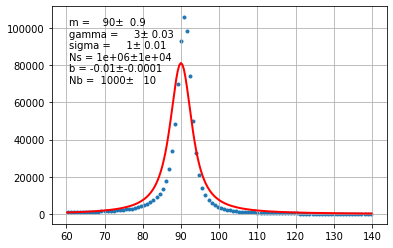

In [8]:
minuit = iminuit.Minuit(binned_likelihood, Ns=1E6, Nb=1E3, m=90,gamma=3,sigma=1,b=-0.01, limit_b=(-0.1,0), limit_gamma=(0.5,5), limit_sigma=(0.5,5))
#minuit = iminuit.Minuit(binned_likelihood, Ns=1E6, Nb=1E3, meam=90,sigma=3,b=-0.01)
#minuit = iminuit.Minuit(binned_likelihood, Ns=1E6, Nb=1E3, m=90, gamma=3,b=-0.01)
#minuit = iminuit.Minuit(binned_likelihood, Ns=1E6, Nb=1E3, mean=90, sigma=3, alpha = 1, n=1, b=-0.01)
binned_likelihood.draw(minuit);

Finally, we do the fit using the MIGRAD algorithm and we display the result.

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4304                       │        Nfcn = 323 (323 total)        │
│ EDM = 9.02e-07 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m     │  90.7420  │  0.0032   │            │            │         │         │       │
│ 1 │ gamma │   1.676   │   0.006   │            │            │   0.5   │    5    │       │
│ 2 │ sigma │   0.965   │   0.009   │            │            │   0.5   │    5    │       │
│ 3 │ Ns    │  837.2e3  │   1.0e3   │            │            │         │         │       │
│ 4 │ b     │ -54.8e-3  │  1.0e-3   │            │            │  -0.1   │    0    │       │
│ 5 │ Nb    │  63.3e3   │   1.0e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

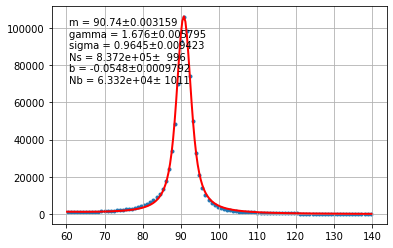

In [9]:
migradfit = minuit.migrad()
#minuit.minos()
binned_likelihood.draw(minuit);
migradfit

Lets do a better plot:

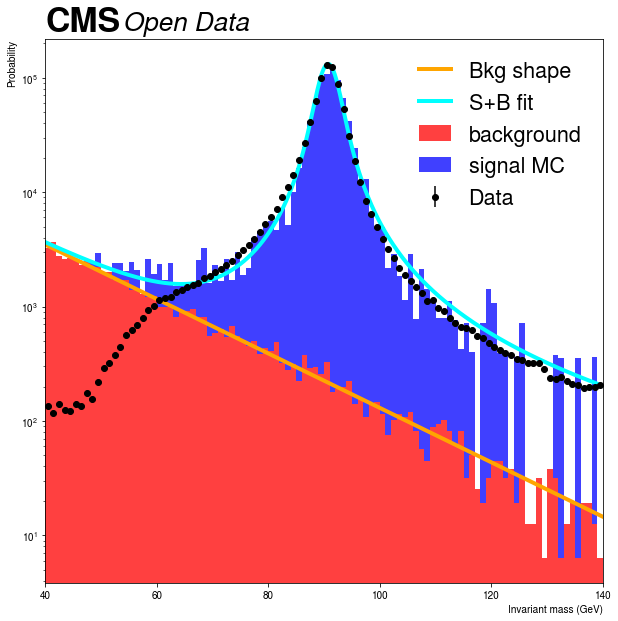

In [10]:
def useFit(migradfit):
    for param in migradfit[1]:
        globals()[param.name] = param.value
        globals()[f"{param.name}_unc"] = param.error
useFit(migradfit)

bkg    = lphys.sample(lphys.randomSample(lambda x: background_pdf(x,b,Nb),xlim,nbins,size=10000),
                      "background","red",integral=Nb)
signal = lphys.sample(selected_simu["invMass"],
                      "signal MC","blue",integral=Ns)

bkg_model = lphys.curve(lambda x:background_pdf(x,b,Nb),'Bkg shape',"orange",4)
tot_model = lphys.curve(lambda x:background_pdf(x,b,Nb)+signal_pdf(x,m,gamma,sigma,Ns),'S+B fit','cyan',4)

lphys.plot(selected_data["invMass"], [bkg,signal], [bkg_model,tot_model],
           xlim, 'Invariant mass (GeV)', 'Probability', 
           nbins, islog=True, color='g', density=False)

Before concluding, we should look more closely at the fit results.
Want to extract quantities like the purity or the number of Z bosons, but we are also interested in the uncertainties and correlations, that we can access through the covariance matrix.

Summary data:

Purity: 95.86 +/- 0.11 %
Selection efficiency: 24.15 %
N_Z = 837188 +/- 996
N_bkg = 63324 +/- 1011
N_data = 873308


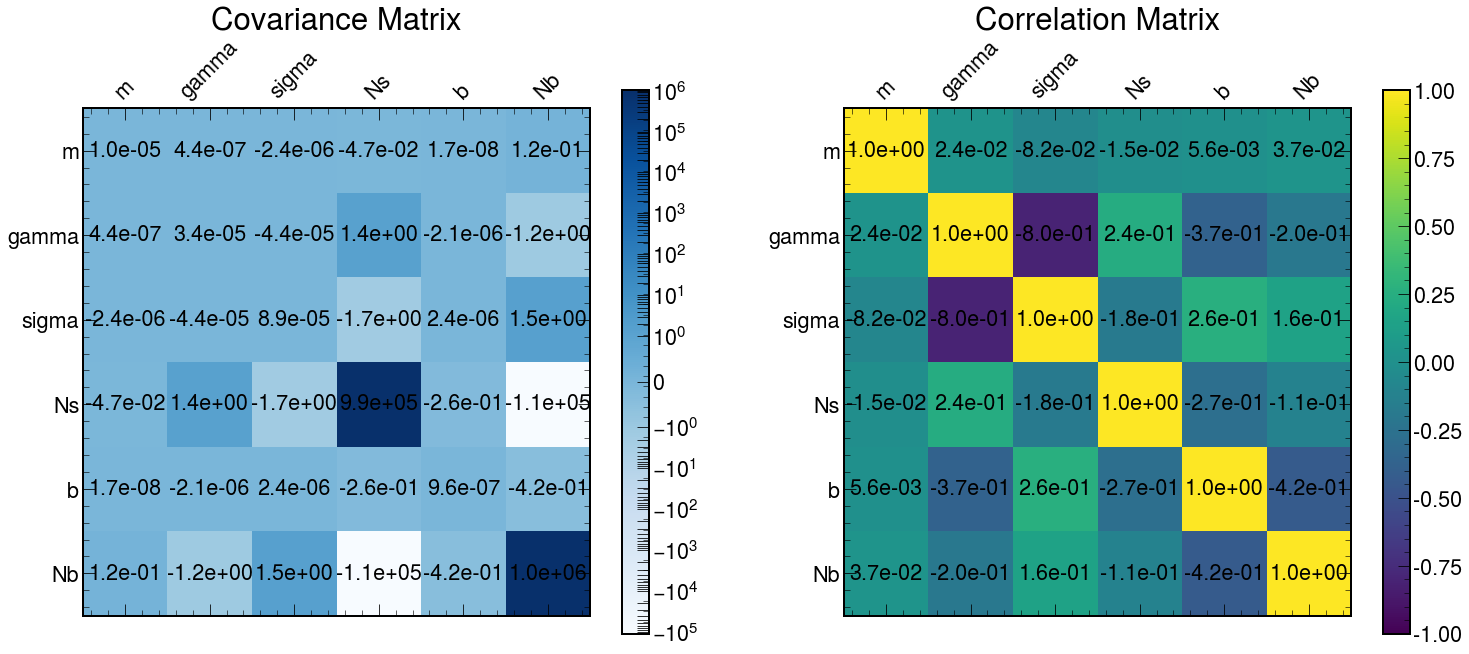

In [11]:
N = len(selected_data)
print("Summary data:\n")
print(f"Purity: { Ns/N*100:.2f} +/- {Ns_unc/N*100:.2f} %")
print(f"Selection efficiency: {len(selected_simu)/simutree.num_entries*100} %")
print(f"N_Z = {Ns:.0f} +/- {Ns_unc:.0f}")
print(f"N_bkg = {Nb:.0f} +/- {Nb_unc:.0f}")
print(f"N_data = {N}")

cov = minuit.np_covariance()
corr = lphys.correlation_from_covariance(cov)
fig, axs = plt.subplots(1, 2,figsize=(25, 10), sharey=False)
lphys.matrixPlot(fig,axs[1],corr,iminuit.describe(binned_likelihood),mrange=(-1,1))
lphys.matrixPlot(fig,axs[0],cov,iminuit.describe(binned_likelihood),"Blues",mrange="log")
axs[0].set_title('Covariance Matrix')
axs[1].set_title('Correlation Matrix')
plt.show()

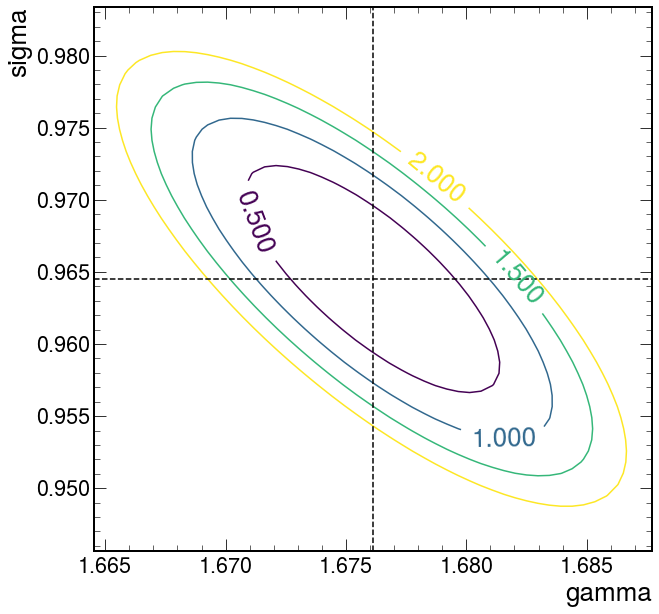

In [12]:
minuit.draw_contour("gamma", "sigma");